In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster", font_scale=1.3)

import missingno as msno
import pandas_profiling

from sklearn.datasets import make_blobs
import time

ImportError: No module named 'tqdm'

In [24]:
# Uncomment one of the following lines and run the cell:

# df = pd.read_csv("redcard.csv.gz", compression='gzip')
# df = pd.read_csv("https://github.com/cmawer/pycon-2017-eda-tutorial/raw/master/data/redcard/redcard.csv.gz", compression='gzip')

In [4]:
def save_subgroup(dataframe, g_index, subgroup_name, prefix='raw_'):
    save_subgroup_filename = "".join([prefix, subgroup_name, ".csv.gz"])
    dataframe.to_csv(save_subgroup_filename, compression='gzip', encoding='UTF-8')
    test_df = pd.read_csv(save_subgroup_filename, compression='gzip', index_col=g_index, encoding='UTF-8')
    # Test that we recover what we send in
    if dataframe.equals(test_df):
        print("Test-passed: we recover the equivalent subgroup dataframe.")
    else:
        print("Warning -- equivalence test!!! Double-check.")

In [5]:
def load_subgroup(filename, index_col=[0]):
    return pd.read_csv(filename, compression='gzip', index_col=index_col)

In [6]:
clean_players = load_subgroup("cleaned_players.csv.gz")
players = load_subgroup("raw_players.csv.gz", )
countries = load_subgroup("raw_countries.csv.gz")
referees = load_subgroup("raw_referees.csv.gz")
agg_dyads = pd.read_csv("raw_dyads.csv.gz", compression='gzip', index_col=[0, 1])
# tidy_dyads = load_subgroup("cleaned_dyads.csv.gz")
tidy_dyads = pd.read_csv("cleaned_dyads.csv.gz", compression='gzip', index_col=[0, 1])

## Joining and further considerations

In [7]:
clean_players = load_subgroup("cleaned_players.csv.gz")

In [8]:
temp = tidy_dyads.reset_index().set_index('playerShort').merge(clean_players, left_index=True, right_index=True)

In [9]:
temp.shape

(371813, 10)

In [10]:
tidy_dyads.head()

redcard
refNum playerShort                
1      lucas-wilchez             0
2      john-utaka                0
4      aaron-hughes              0
       aleksandar-kolarov        0
       alexander-tettey          0

In [11]:
(tidy_dyads.groupby(level=0)
           .sum()
           .sort_values('redcard', ascending=False)
           .rename(columns={'redcard':'total redcards given'})).head()

,total redcards given
refNum,
468,49
432,49
449,47
916,42
2073,36


In [15]:
(tidy_dyads.groupby(level=1)
           .sum()
           .sort_values('redcard', ascending=False)
           .rename(columns={'redcard':'total redcards received'})).head()

,total redcards received
playerShort,
cyril-jeunechamp,19
sergio-ramos,19
gary-medel,16
ballesteros,15
juanfran,15


In [16]:
tidy_dyads.head() 

redcard
refNum playerShort                
1      lucas-wilchez             0
2      john-utaka                0
4      aaron-hughes              0
       aleksandar-kolarov        0
       alexander-tettey          0

In [17]:
total_ref_games = tidy_dyads.groupby(level=0).size().sort_values(ascending=False)
total_player_games = tidy_dyads.groupby(level=1).size().sort_values(ascending=False)

In [18]:
total_ref_given = tidy_dyads.groupby(level=0).sum().sort_values(ascending=False,by='redcard')
total_player_received = tidy_dyads.groupby(level=1).sum().sort_values(ascending=False, by='redcard')

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


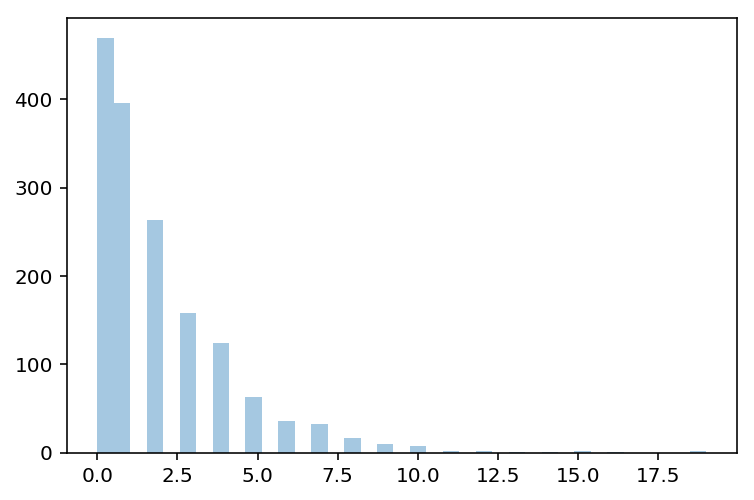

In [19]:
sns.distplot(total_player_received, kde=False);

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


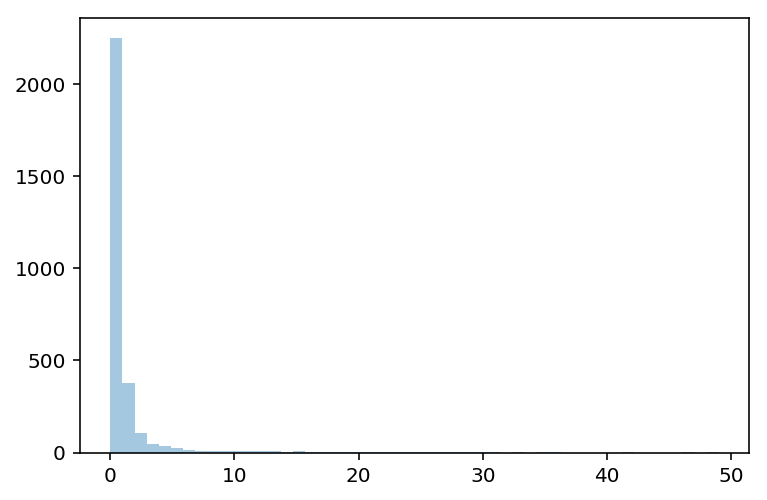

In [20]:
sns.distplot(total_ref_given, kde=False);

In [39]:
tidy_dyads.groupby(level=1).sum().sort_values(ascending=False, by='redcard').head()

,redcard
playerShort,
cyril-jeunechamp,19
sergio-ramos,19
gary-medel,16
ballesteros,15
juanfran,15


In [22]:
tidy_dyads.sum()

redcard    3092
dtype: int64

In [23]:
tidy_dyads.sum(), tidy_dyads.count(), tidy_dyads.sum()/tidy_dyads.count()

(redcard    3092
 dtype: int64, redcard    373067
 dtype: int64, redcard    0.008288
 dtype: float64)

In [24]:
player_ref_game = (tidy_dyads.reset_index()
                               .set_index('playerShort')
                                       .merge(clean_players,
                                              left_index=True,
                                              right_index=True)
                  )

In [43]:
player_ref_game.head()

,refNum,redcard,height,weight,skintone,position_agg,weightclass,heightclass,skintoneclass,age_years
playerShort,,,,,,,,,,
aaron-hughes,4,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"(-0.001, 0.125]",33.149897
aaron-hughes,66,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"(-0.001, 0.125]",33.149897
aaron-hughes,77,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"(-0.001, 0.125]",33.149897
aaron-hughes,77,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"(-0.001, 0.125]",33.149897
aaron-hughes,77,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"(-0.001, 0.125]",33.149897


In [25]:
player_ref_game.shape

(371813, 10)

In [26]:
bootstrap = pd.concat([player_ref_game.sample(replace=True, 
                                              n=10000).groupby('skintone').mean() 
                       for _ in range(100)])

In [27]:
player_ref_game.sample(replace=True,n=10000).groupby('skintone').mean()

,refNum,redcard,height,weight,age_years
skintone,,,,,
0.000,1531.503650,0.008029,182.308394,76.312044,28.060534
0.125,1501.151792,0.005622,182.680253,76.063247,28.080587
0.250,1498.350726,0.010188,181.579500,76.305650,29.110892
0.375,1289.050575,0.011494,181.314943,76.105747,28.186514
0.500,1580.124251,0.007485,180.625749,74.889222,27.872301
0.625,1633.666667,0.005208,182.760417,75.614583,27.032683
0.750,1547.271218,0.009225,180.608856,76.378229,27.797323
0.875,1678.386667,0.000000,182.751111,77.755556,27.817951
1.000,1569.438433,0.011194,181.817164,75.944030,28.094451


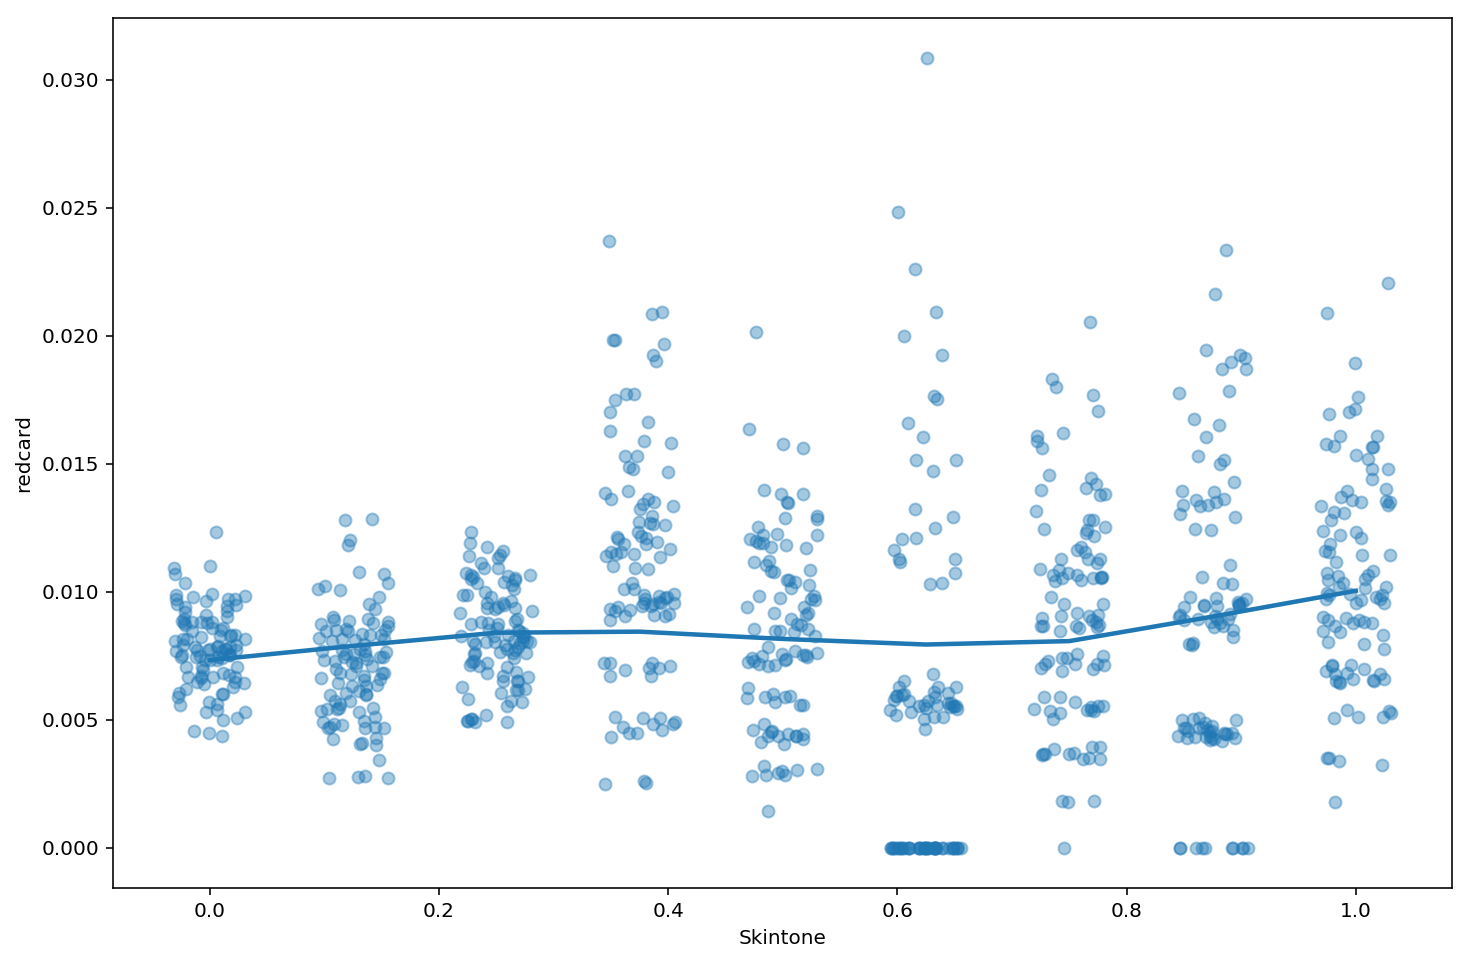

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.regplot(bootstrap.index.values,
                 y='redcard',
                 data=bootstrap,
                 lowess=True,
                 scatter_kws={'alpha':0.4,},
                 x_jitter=(0.125 / 4.0))
ax.set_xlabel("Skintone");